<a href="https://colab.research.google.com/github/RodrigoAgronomia/smart_tmp/blob/master/python/Tracking_Train_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%%capture
!pip install livelossplot
%cd /content
!git clone --depth 1 https://github.com/RodrigoAgronomia/smart_tmp.git
%cd /content/smart_tmp
!git pull
%cd /content/smart_tmp/python

remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10 (delta 4), reused 10 (delta 4), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/RodrigoAgronomia/smart_tmp
   07f8be1..d6e01c5  master     -> origin/master
Updating 07f8be1..d6e01c5
Fast-forward
 data/Tracking.pth                                  | Bin 503233 -> 503233 bytes
 .../Tracking_Train_Model_-checkpoint.ipynb         | 476 ---------------------
 2 files changed, 476 deletions(-)
 delete mode 100644 python/.ipynb_checkpoints/Tracking_Train_Model_-checkpoint.ipynb
/content/smart_tmp/python


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from cnn import SegmentationModel as net
from torch.autograd import Variable
from livelossplot import PlotLosses

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, im_dir, im_list, lbl_list):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        '''          
        self.im_dir = im_dir
        self.im_list = im_list
        self.lbl_list = lbl_list      

    def __len__(self):
        return len(self.im_list)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.im_list[idx]
        label_name = self.lbl_list[idx]
        
        image = cv2.imread(os.path.join(self.im_dir, image_name), cv2.IMREAD_COLOR)
        image = np.moveaxis(image, 2, 0)
        image = image.astype('float')
        image -= 128
        image /= 35
        image = torch.from_numpy(image)

        label = cv2.imread(os.path.join(self.im_dir, label_name), cv2.IMREAD_GRAYSCALE)
        label = torch.from_numpy(label)

        image = Variable(image).to(device, dtype=torch.float)
        label = Variable(label).to(device, dtype=torch.long)
        
        return (image, label)

In [0]:
# Diretorio das imagens
im_dir  = '/content/drive/My Drive/IMG_Datasets/Eucalipto2/Frames_LR/'
data_dir  = '../data/'

img_ext = '.jpg'
msk_ext = '.png'
imfxy = sorted(os.listdir(im_dir))
# imfxy = imfxy[80:100]
imfx = [i for i in imfxy if i.endswith(img_ext)]
imfx = np.array(imfx)

imfy = [i for i in imfxy if i.endswith(msk_ext) and not i.endswith('_col.png')]
imfy = np.array(imfy)


In [8]:
print(len(imfx), len(imfy))

887 887


In [0]:
im_train = np.arange(len(imfx))
brks = np.int0(np.linspace(0, len(imfx), 11))

fold = 0
np.random.seed(12345)
fold_ord = np.random.choice(im_train, len(imfx), replace=False)
im_val = np.sort(fold_ord[brks[fold]:brks[fold +1]])
im_train = np.setdiff1d(im_train,im_val)

In [0]:
train_dataset =  MyDataset(im_dir, imfx[im_train], imfy[im_train])
val_dataset =  MyDataset(im_dir, imfx[im_val], imfy[im_val])

In [11]:
print(len(train_dataset), len(val_dataset))

799 88


In [0]:
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=10,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=5,
                          shuffle=False,
                          num_workers=0
                         )

In [18]:
# Atribui o modelo
model = net.EESPNet_Seg(3, s=0.5, pretrained='', gpus=1)
model = model.to(device)
model.load_state_dict(torch.load('../data/Tracking.pth', map_location=device))

print(count_parameters(model))


96630


In [0]:
learning_rate = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

In [15]:
min_loss = 1e9
bad_epochs = 0

liveloss = PlotLosses()
for epoch in range(1000):
    bad_epochs += 1
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for (imgs, labels) in train_loader:
        
        #-------------------------------------------
        # Obtem o output
        pred, feat = model(imgs)
        loss = criterion(pred, labels)
        
        # Limpa os gradientes
        optimizer.zero_grad()

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        epoch_loss.append(loss.data.item())
    
    model.eval()
    with torch.no_grad():
        for (imgs, labels) in val_loader:

            pred, feat = model(imgs)
            loss = criterion(pred, labels)

            val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    #save the model
    model_file_name = '../data/Tracking.pth'
    if val_loss < min_loss:
        torch.save(model.state_dict(), model_file_name)
        min_loss = val_loss
        bad_epochs = 0
    if bad_epochs > 100:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw()
    print('Fold: %d, [%d:%d] loss: %.3f time:%.2f' % (fold, bad_epochs, epoch, epoch_loss, time_taken))
    

KeyboardInterrupt: ignored

In [19]:
# Carrega os pesos de um modelo salvo
# model.load_state_dict(torch.load('../data/Tracking.pth', map_location=device))

# Coloca em modo de avaliação
model.eval()

print('Modelo OK')

Modelo OK


In [20]:
start_time = time.time()
y_preds = []
y_obs = []
x_obs = []

with torch.no_grad():
    for (imgs, labels) in val_loader:
        # Obtem o output
        pred, feat = model(imgs)
        y_preds.append(pred.cpu().data.numpy())
        x_obs.append(imgs.cpu().data.numpy())
        y_obs.append(labels.cpu().data.numpy())

y_preds = np.concatenate(y_preds)
x_obs = np.concatenate(x_obs)
y_obs = np.concatenate(y_obs)

time_taken = time.time() - start_time
print('time:%.2f' % (time_taken))

time:49.34


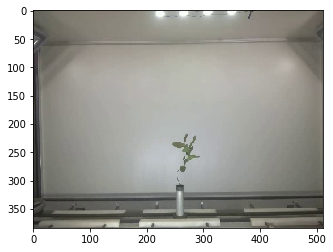

In [22]:
idx = 3
im = np.moveaxis(x_obs[idx].copy(), 0, 2)
im *= 35
im += 128
im = im.astype('int')
plt.imshow(im[:,:,[2,1,0]])

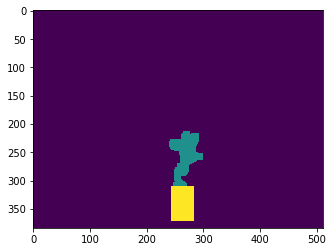

In [23]:
plt.imshow(y_obs[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


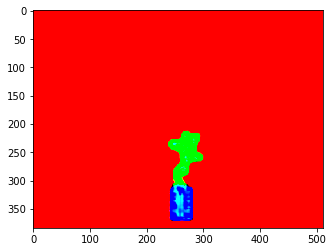

In [24]:
imp = np.moveaxis(y_preds[idx].copy(), 0, 2)
plt.imshow(imp)